# Predefined Candidates

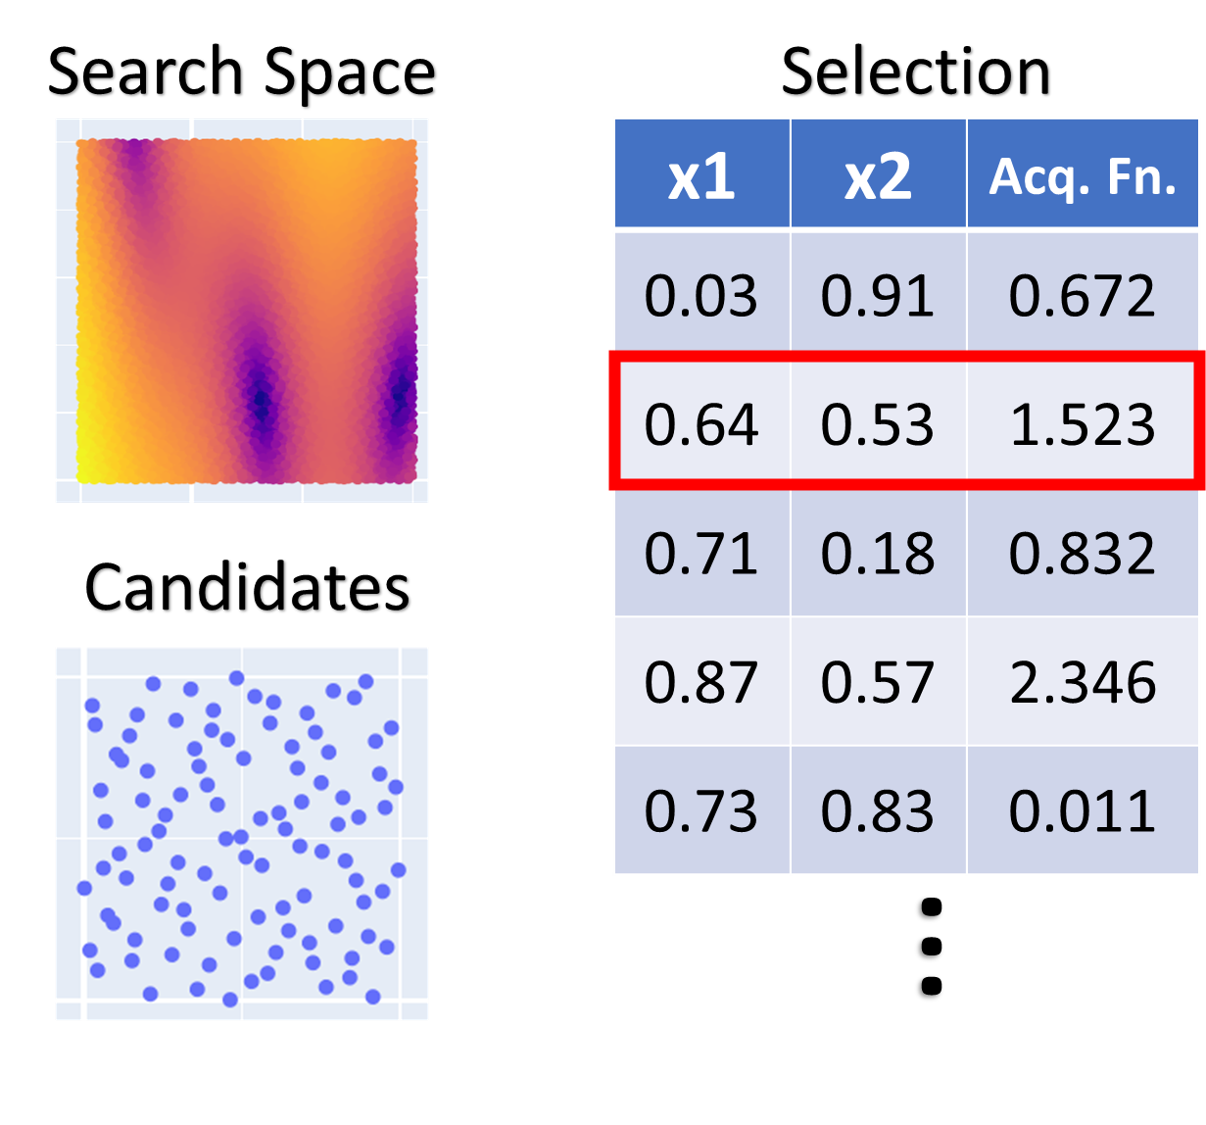

In [2]:
# For notebook gallery thumbnail
from IPython.display import Image
Image(filename="./../predefined-list-of-candidates.png")


Acquisition Function Evaluation using a List of Predefined Candidate Solutions

https://github.com/facebook/Ax/issues/771#issuecomment-1011742002

In [1]:
# %% imports
import numpy as np
import pandas as pd

from sklearn.datasets import make_regression
from sklearn.preprocessing import MinMaxScaler, normalize

from ax.modelbridge.generation_strategy import GenerationStrategy, GenerationStep
from ax.modelbridge.registry import Models

from ax.service.ax_client import AxClient
from ax.service.utils.instantiation import ObjectiveProperties

from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement
from ax.models.torch.botorch_modular.surrogate import Surrogate

from ax.core.observation import ObservationFeatures
from botorch.models.gp_regression import SingleTaskGP

In [70]:
n_train = 7
unique_components = ["filler_A", "filler_B", "resin_A", "resin_B", "resin_C"]
objective_names = ["yield_strength", "elongation"]

X_train, y_train = make_regression(
    n_samples=n_train,
    n_features=5,
    n_informative=5,
    n_targets=len(objective_names),
    noise=0.1,
    random_state=10,
)

X_train = MinMaxScaler().fit_transform(X_train)
X_train = normalize(X_train, norm="l1")

y_train[:, 0] = (
    MinMaxScaler(feature_range=(0, 100))
    .fit_transform(y_train[:, 0].reshape(-1, 1))
    .ravel()
)
y_train[:, 1] = (
    MinMaxScaler(feature_range=(0, 5))
    .fit_transform(y_train[:, 1].reshape(-1, 1))
    .ravel()
)

X_train = pd.DataFrame(X_train, columns=unique_components)

# make back into a single-objective (i.e., ignore second objective)
objective_names = objective_names[:1]
y_train = pd.DataFrame(y_train[:, 0], columns=objective_names)

In [71]:
filler_upper_bound = 0.9
resin_upper_bound = 1 - 0.1
parameters = [
    {"name": component, "type": "range", "bounds": [0.0, 1.0]}
    for component in unique_components[:-1]
]

In [72]:
separator = " + "
filler_components = [
    component for component in unique_components[:-1] if "filler" in component
]
filler_lower_constraint = (
    separator.join(filler_components) + f" >= {1 - resin_upper_bound}"
)
filler_upper_constraint = (
    separator.join(filler_components) + f" <= {filler_upper_bound}"
)

composition_constraint = separator.join(unique_components[:-1]) + " <= 1.0"

parameter_constraints = [
    composition_constraint,
    filler_lower_constraint,
    filler_upper_constraint,
]
parameter_constraints

['filler_A + filler_B + resin_A + resin_B <= 1.0',
 'filler_A + filler_B >= 0.09999999999999998',
 'filler_A + filler_B <= 0.9']

In [78]:
gs = GenerationStrategy(
    steps=[
        # # 1. Initialization step (does not require pre-existing data and is well-suited for
        # # initial sampling of the search space)
        # GenerationStep(
        #     model=Models.SOBOL,
        #     num_trials=10,  # How many trials should be produced from this generation step
        #     # min_trials_observed=3,  # How many trials need to be completed to move to next model
        #     max_parallelism=None,  # Max parallelism for this step
        #     model_kwargs={
        #         "seed": 999,
        #         "fallback_to_sample_polytope": True,
        #     },  # Any kwargs you want passed into the model
        #     model_gen_kwargs={},  # Any kwargs you want passed to `modelbridge.gen`
        # ),
        # 2. Bayesian optimization step (requires data obtained from previous phase and learns
        # from all data available at the time of each new candidate generation call)
        GenerationStep(
            model=Models.BOTORCH_MODULAR,
            num_trials=-1,  # No limitation on how many trials should be produced from this step
            max_parallelism=None,  # Parallelism limit for this step, often lower than for Sobol
            # More on parallelism vs. required samples in BayesOpt:
            # https://ax.dev/docs/bayesopt.html#tradeoff-between-parallelism-and-total-number-of-trials
            model_kwargs={
                # https://github.com/facebook/Ax/issues/768#issuecomment-1009007526
                "fit_out_of_design": True,
                # FullyBayesianBotorchModel not working, see https://github.com/facebook/Ax/issues/771#issuecomment-1013535992
                "surrogate": Surrogate(SingleTaskGP),
                "botorch_acqf_class": qNoisyExpectedImprovement,
            },
        ),
    ]
)

objectives = {
    objective_name: ObjectiveProperties(minimize=False)
    for objective_name in objective_names
}

ax_client = AxClient(generation_strategy=gs)
ax_client.create_experiment(
    name="predefined_candidates",
    parameters=parameters,
    parameter_constraints=parameter_constraints,
    objectives=objectives,
)

[INFO 02-22 21:32:34] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 02-22 21:32:34] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter filler_A. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 02-22 21:32:34] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter filler_B. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 02-22 21:32:34] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter resin_A. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 02-22 21:32:3

In [79]:
X_train

,filler_A,filler_B,resin_A,resin_B,resin_C
0,0.263170,0.161356,0.319319,0.177511,0.078643
1,0.233281,0.191723,0.165822,0.409174,0.000000
2,0.067263,0.225302,0.341151,0.186902,0.179382
3,0.242482,0.000000,0.000000,0.363517,0.394001
4,0.000000,0.346443,0.318884,0.272197,0.062476
5,0.293613,0.293613,0.183609,0.208137,0.021027
6,0.268568,0.312212,0.096869,0.000000,0.322350


In [80]:
for i in range(n_train):
    _, trial_index = ax_client.attach_trial(X_train.iloc[i, :-1].to_dict())
    ax_client.complete_trial(
        trial_index=trial_index, raw_data=y_train.iloc[i].to_dict()
    )

unique_components = ["filler_A", "filler_B", "resin_A", "resin_B", "resin_C"]

# candidates for which to evaluate the acquisition function on
X_candidates = np.array(
    [
        [0.4, 0.4, 0.0, 0.0, 0.2],
        [0.5, 0.0, 0.0, 0.5, 0.0],
        [0.5, 0.3, 0.0, 0.2, 0.0],
        [0.5, 0.0, 0.0, 0.5, 0.0],
        [0.0, 0.6, 0.4, 0.0, 0.0],
        [0.6, 0.0, 0.4, 0.0, 0.0],
        [0.0, 0.6, 0.2, 0.2, 0.0],
    ]
)

X_candidates = pd.DataFrame(X_candidates[:, :-1], columns=unique_components[:-1])

# ax_client.get_next_trial() # by uncommenting this, model_bridge is assigned, but evaluate_acquisition_function is NotImplemented
# **EDIT**: 2021-01-19, need to deepcopy ax_client so it doesn't change underlying parameter bounds
# ax_client_copy = deepcopy(ax_client)

ax_client.fit_model()

model_bridge = ax_client.generation_strategy.model

observation_features = [
    ObservationFeatures(x) for x in X_candidates.to_dict(orient="records")
]

# REVIEW: batch optimization through iterative modeling available in
# service_predefined.py from Ultradent-BO

# `acqf_values` is a list of floats (since we can evaluate acqf for multiple points at
# once);
# ordering corresponds to order of points in `observation_features` input
acqf_values = model_bridge.evaluate_acquisition_function(
    # Each `ObservationFeatures` below represents one point in experiment (untransformed) search space:
    observation_features=observation_features
)

max_value = max(acqf_values)
max_index = acqf_values.index(max_value)
next_experiment = X_candidates.iloc[max_index]

model = ax_client.generation_strategy.model
y_pred, y_var = model.predict([ObservationFeatures(next_experiment)])

[INFO 02-22 21:32:34] ax.service.ax_client: Attached custom parameterization {'filler_A': 0.26317, 'filler_B': 0.161356, 'resin_A': 0.319319, 'resin_B': 0.177511} as trial 0.
[INFO 02-22 21:32:34] ax.service.ax_client: Completed trial 0 with data: {'yield_strength': (11.076321, None)}.
[INFO 02-22 21:32:34] ax.service.ax_client: Attached custom parameterization {'filler_A': 0.233281, 'filler_B': 0.191723, 'resin_A': 0.165822, 'resin_B': 0.409174} as trial 1.
[INFO 02-22 21:32:34] ax.service.ax_client: Completed trial 1 with data: {'yield_strength': (31.772108, None)}.
[INFO 02-22 21:32:34] ax.service.ax_client: Attached custom parameterization {'filler_A': 0.067263, 'filler_B': 0.225302, 'resin_A': 0.341151, 'resin_B': 0.186902} as trial 2.
[INFO 02-22 21:32:35] ax.service.ax_client: Completed trial 2 with data: {'yield_strength': (75.022848, None)}.
[INFO 02-22 21:32:35] ax.service.ax_client: Attached custom parameterization {'filler_A': 0.242482, 'filler_B': 0.0, 'resin_A': 0.0, 'res